# Example notebook

In [46]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import PolynomialFeatures
import datetime 
from datetime import timedelta
import pytz
from pytz import timezone
import tarfile
from numpy import load
import os
from sklearn.manifold import TSNE
import h5py
from sklearn.decomposition import PCA as sklearnPCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch
import scipy
from scipy import spatial
from scipy import stats
import pylab
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import librosa
import scipy.signal
import scipy.ndimage
import matplotlib.dates as md
import sys

In [15]:
sys.path.insert(1, '../modules')
import data
import display

Loading the hdf5 files

In [3]:
h5 = h5py.File('../data/sound_data_improved.hdf5', 'r')

In [4]:
d = h5['sound_data']

# Creating subsample of 10000 points from all four sensors

In [5]:
sample_nums = np.random.choice(range(d.shape[0]), 10000, replace = False)

In [6]:
index = np.zeros(d.shape[0]).astype('bool')
index[sample_nums] = True

# Reading and graphing data from one sensor

Reading June data from one of the sensors

In [7]:
df = pd.read_csv("../data/sonycnode-b827ebc178d2.sonyc.csv", skiprows = 2, low_memory = False)
df.head()

,timestamp,dBAS
0,1.559362e+09,63.53
1,1.559362e+09,63.73
2,1.559362e+09,64.94
3,1.559362e+09,63.09
4,1.559362e+09,61.66


Creating two numpy array with the timestamps for June and the corresponding SPL values for June

In [8]:
time_arr = np.empty(df.shape[0], dtype = datetime.datetime)
timestamp_arr = df['timestamp'].values
dBAS_arr = df['dBAS'].values

In [18]:
time_arr = [data.convert_timestamps(x) for x in timestamp_arr]

Creating a new dataframe with timestamps in datetime format

In [35]:
time_df = df
time_df['timestamp'] = time_arr
time_df.tail()

,timestamp,dBAS
2589895,2019-07-01 00:00:38.810000-04:00,66.04
2589896,2019-07-01 00:00:39.810000-04:00,69.75
2589897,2019-07-01 00:00:40.810000-04:00,68.68
2589898,2019-07-01 00:00:41.810000-04:00,73.17
2589899,2019-07-01 00:00:42.810000-04:00,77.04


# Clustering on 45 dimensions

Running PCA on the embeddings in order to reduce dimensionality to 45

In [19]:
pca_45 = sklearnPCA(45)
projected_45 = pca_45.fit_transform(d['feature_vector'])

In [21]:
b827ebc178d2_mask = data.get_sensor_mask(d['sensor_id'], b'sonycnode-b827ebc178d2.sonyc')
b827ebc178d2_transformed = projected_45[b827ebc178d2_mask]
b827ebc178d2_timestamps = d[b827ebc178d2_mask, 'timestamp']
b827ebc178d2_timestamps_dt = [data.convert_timestamps(x) for x in b827ebc178d2_timestamps]

# Dataframe with timestamps and cluster assignment

In [28]:
truck_clusters = [5, 10, 11, 18, 20, 37, 42, 57, 63]

Dataframe spanning over the whole month


In [22]:
all_cluster_assignments = data.get_cluster_assignments(64, b827ebc178d2_transformed, projected_45[index])
seconds_b827ebc178d2_timestamps_dt = [x.replace(microsecond=0) for x in b827ebc178d2_timestamps_dt]

In [23]:
assignments_df = pd.DataFrame(data={'assignment':all_cluster_assignments}, \
                              index = seconds_b827ebc178d2_timestamps_dt)
assignments_df.head()

,assignment
2019-06-01 00:00:16-04:00,30
2019-06-01 00:00:17-04:00,26
2019-06-01 00:00:18-04:00,52
2019-06-01 00:00:19-04:00,26
2019-06-01 00:00:20-04:00,26


Removed all duplicate entries in dataframe

In [24]:
removed_assignments_df = assignments_df[~assignments_df.index.duplicated()]

In [25]:
complete = pd.date_range(datetime.datetime(2019, 6, 1, 4), datetime.datetime(2019, 7, 1, 4), periods=3600*24*30)
seconds_complete = [x.replace(microsecond=0, nanosecond=0) for x in complete]
aware_seconds_complete = [pytz.utc.localize(x) for x in seconds_complete]
tz_seconds_complete = [x.astimezone(pytz.timezone('US/Eastern')) for x in aware_seconds_complete]

Replaces actual cluster assignment with 0 for no assignment value, 1 for a truck cluster, 2 for every other cluster

In [26]:
complete_assignments_df = removed_assignments_df.reindex(tz_seconds_complete, axis='index', fill_value = 0)

In [29]:
complete_assignments_df = complete_assignments_df.replace(truck_clusters, 1)
complete_assignments_df = complete_assignments_df.replace(range(2,64), 2)

In [30]:
complete_assignments_df.head()

,assignment
2019-06-01 00:00:00-04:00,0
2019-06-01 00:00:01-04:00,0
2019-06-01 00:00:02-04:00,0
2019-06-01 00:00:03-04:00,0
2019-06-01 00:00:04-04:00,0


In [31]:
complete_assignments_df.tail()

,assignment
2019-06-30 23:59:55-04:00,2
2019-06-30 23:59:56-04:00,0
2019-06-30 23:59:57-04:00,0
2019-06-30 23:59:58-04:00,0
2019-07-01 00:00:00-04:00,0


# Dataframe with timestamp and SPL value

In [36]:
time_df.head()

,timestamp,dBAS
0,2019-06-01 00:00:42.690000-04:00,63.53
1,2019-06-01 00:00:43.690000-04:00,63.73
2,2019-06-01 00:00:44.690000-04:00,64.94
3,2019-06-01 00:00:45.690000-04:00,63.09
4,2019-06-01 00:00:46.690000-04:00,61.66


In [37]:
naive_time_df = [x.replace(tzinfo=None) for x in time_df['timestamp']]

In [38]:
seconds_complete_timestamp = [x.replace(microsecond=0) for x in time_df['timestamp']]

In [39]:
spl_df = pd.DataFrame(data={'dBAS': dBAS_arr}, index=seconds_complete_timestamp)

In [40]:
spl_df.tail()

,dBAS
2019-07-01 00:00:38-04:00,66.04
2019-07-01 00:00:39-04:00,69.75
2019-07-01 00:00:40-04:00,68.68
2019-07-01 00:00:41-04:00,73.17
2019-07-01 00:00:42-04:00,77.04


# Joining cluster assignment dataframe and SPL dataframe

This dataframe is for the whole month, so if you slice it based on date, it will give you different subsets of information. There is no need to recreate any dataframes.

In [41]:
all_joined_df = spl_df.join(complete_assignments_df)

In [42]:
all_joined_df.loc[pd.isnull(all_joined_df['assignment']), 'assignment'] = 0

Gets rid of the extra 42 seconds of data in July 1st

In [43]:
all_joined_df_cut = all_joined_df[:-42]

In [44]:
all_joined_df_cut.head()

,dBAS,assignment
2019-06-01 00:00:42-04:00,63.53,1.0
2019-06-01 00:00:43-04:00,63.73,2.0
2019-06-01 00:00:44-04:00,64.94,2.0
2019-06-01 00:00:45-04:00,63.09,1.0
2019-06-01 00:00:46-04:00,61.66,1.0


# Creating matrix of SPL values over each day

Matrix of time and day, containing SPL values for every second of every day (only weekdays)

In [58]:
spl_complete = spl_df['dBAS']

In [59]:
beginning_spl_indices = \
pd.date_range(datetime.datetime(2019, 6, 1, 4, 0, 0), datetime.datetime(2019, 6, 1, 4, 0, 42), periods=42)
beginning_spl_indices = [x.replace(microsecond=0, nanosecond=0) for x in beginning_spl_indices]
beginning_spl_indices = [pytz.utc.localize(x) for x in beginning_spl_indices]
beginning_spl_indices = [x.astimezone(pytz.timezone('US/Eastern')) for x in beginning_spl_indices]

In [60]:
beginning_spl = pd.Series(np.nan, index=beginning_spl_indices)

In [61]:
spl_complete_2 = pd.concat([beginning_spl, spl_complete])

In [62]:
spl_complete_month = spl_complete_2[:-43]

# Creating median array for weekends

In [63]:
spl_complete_month_weekends = spl_complete_month[spl_complete_month.index.dayofweek >= 5]

In [ ]:
spl_complete_month_weekdays = spl_complete_month[spl_complete_month.index.dayofweek < 5]

In [64]:
spl_complete_month_weekends = spl_complete_month_weekends[~spl_complete_month_weekends.index.duplicated()]

In [ ]:
weekend_medians = data.get_median(spl_complete_month_weekends)

[ 1  2  8  9 15 16 22 23 29 30]
1: 86337
2: 86338
8: 86335
9: 86201
15: 86335
16: 86338
22: 86335
23: 86244


In [ ]:
weekend_medians

In [123]:
weekday_medians = data.get_median(spl_complete_month_weekdays)

[ 3  4  5  6  7 10 11 12 13 14 17 18 19 20 21 24 25 26 27 28]
3: 86340
4: 86338
5: 86339
6: 86333
7: 86341
10: 86361
11: 86337
12: 86325
13: 86349
14: 86338
17: 86338
18: 86337
19: 86339
20: 86341
21: 86336
24: 86316
25: 86338
26: 86087
27: 86218
28: 86356


In [124]:
weekday_medians

array([57.755, 58.22 , 57.98 , ..., 58.86 , 58.805, 59.135])

In [125]:
2589898 % len(weekday_medians)

84298

In [129]:
len(scipy.ndimage.gaussian_filter1d(weekday_medians, 1000))

86400

First 42 seconds of June that somehow didn't get included in the measured SPL data

In [133]:
beginning_spl_indices_series = pd.Series(data=beginning_spl_indices)

Creating datetime indices spanning the whole month, with the additional 42 secs in the beginning of June

In [134]:
medians_df_index = pd.concat([beginning_spl_indices_series[0:42], all_joined_df.reset_index()['index']])

In [135]:
month_weekday_median = np.empty(len(medians_df_index))

In [136]:
for i in range(len(medians_df_index)):
    month_weekday_median[i] = weekday_medians[i%len(weekday_medians)]

In [137]:
month_weekday_median

array([57.755, 58.22 , 57.98 , ..., 62.44 , 60.525, 62.255])

In [138]:
weekday_medians_df = pd.DataFrame({'median_dBAS':month_weekday_median}, index=medians_df_index)

In [139]:
weekday_medians_df.tail()

,median_dBAS
2019-07-01 00:00:38-04:00,61.100
2019-07-01 00:00:39-04:00,61.420
2019-07-01 00:00:40-04:00,62.440
2019-07-01 00:00:41-04:00,60.525
2019-07-01 00:00:42-04:00,62.255


# Example Plots

Plots SPL level in green, the shaded parts correspond to audio that is grouped into trucks (red) and non-trucks (gray). SPL peaks are plotted with dots in the same color scheme.

254    2019-06-03 14:04:14-04:00
408    2019-06-03 14:06:48-04:00
1331   2019-06-03 14:22:11-04:00
1608   2019-06-03 14:26:48-04:00
1715   2019-06-03 14:28:35-04:00
Name: index, dtype: datetime64[ns, US/Eastern]
254     76.49
408     74.35
1331    80.15
1608    73.74
1715    69.24
Name: dBAS, dtype: float64


NameError: name 'scipy' is not defined

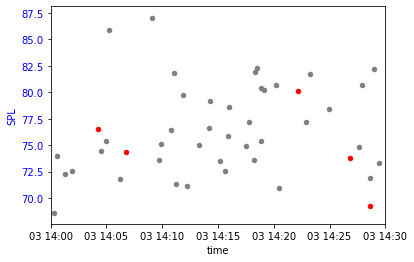

In [54]:
display.plot_truck_clusters(all_joined_df_cut['2019-06-03 14:00:00-04:00':'2019-06-03 14:30:00-04:00'], \
                            7, 11, 15, 'mean')

In [57]:
display.plot_truck_clusters_median(all_joined_df_cut_median['2019-06-03 14:40:00-04:00':'2019-06-03 14:50:00-04:00'], \
                            3, 0.5, 10, 1, 'gaussian')

NameError: name 'all_joined_df_cut_median' is not defined